In [1]:
import AutoOD as aod
import importlib


import numpy as np
import CLAMS as clams
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

importlib.reload(aod)
importlib.reload(clams)



<module 'CLAMS' from '/home/hj/cluster-ambiguity/src/clams/CLAMS.py'>

In [2]:
contamination_arr = np.linspace(0.05, 0.5, 20)
identifier = "npz"
data_name = "abalone"

iteraion = 5



zipfile = np.load(f"./data_sampling/{data_name}.{identifier}", allow_pickle=True)
data, labels = zipfile["positions"], zipfile["labels"]

data = data[::4]


max_nn = int(np.sqrt(data.shape[0])) * 2 
max_nn = max_nn  + (10 - max_nn % 10)
nn_list = np.arange(10, max_nn, 10)
lof_nn_results = {}
contam_nn_results = {}
for nn in nn_list:
	lof_nn_results[nn] = []
	contam_nn_results[nn] = []

contamination_range = (0, 0.5)
contamination_iter = 30

In [3]:

for nn in lof_nn_results.keys():
	print("running nn", nn)
	for _ in tqdm(range(contamination_iter)):
		contam = np.random.uniform(contamination_range[0], contamination_range[1])
		prediction = aod.local_outlier_factor(data, nn, contam)
		data_wo_outliers = data[prediction == 1]
		try:
			ca = clams.ClusterAmbiguity(verbose=0, random_state=0, S=1)
			amb_score = ca.fit(data_wo_outliers)
			lof_nn_results[nn].append(amb_score)
			contam_nn_results[nn].append(contam)
		except:
			pass




running nn 10


 20%|██        | 6/30 [00:44<02:42,  6.78s/it]

In [ ]:
results = {
	"results": lof_nn_results,
	"contamination": contamination_arr.tolist()
}

with open(f"./od_benchmark/results/lof_nn_{data_name}.json", "w") as f:
	json.dump(results, f)



/tmp/ipykernel_24536/3088330683.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({
/tmp/ipykernel_24536/3088330683.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({
/tmp/ipykernel_24536/3088330683.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({


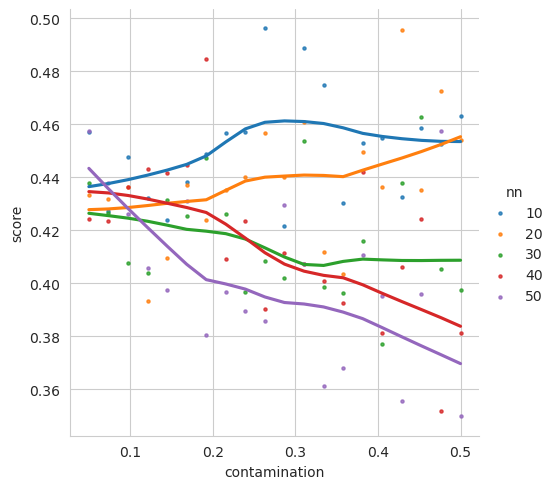

In [16]:
data_name = "clothes"

with open(f"./od_benchmark/results/lof_nn_{data_name}.json", "r") as f:
	results = json.load(f)

lof_nn_results = results["results"]
contamination_arr = np.array(results["contamination"])

df = pd.DataFrame({
	"nn": [],
	"contamination": [],
})

for key in lof_nn_results.keys():
	df = df.append(pd.DataFrame({
		"nn": [key] * len(contamination_arr),
		"contamination": contamination_arr,
		"score": lof_nn_results[key]
	}))

sns.set_style("whitegrid")
sns.lmplot(data=df, x="contamination", y="score", hue="nn", lowess=True, scatter_kws={"s": 5})

## plot the results
# for key in lof_nn_results.keys():
# 	plt.plot(contamination_arr, lof_nn_results[key], label=f"nn={key}")

